# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [3]:
!pip install ipython-autotime
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 8.9 MB/s eta 0:00:01
time: 4.25 s (started: 2021-05-01 13:55:48 +00:00)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils import MultipleTimeSeriesCV, format_time

sns.set_style('whitegrid')
np.random.seed(42) # for cv
idx = pd.IndexSlice
YEAR = 252

time: 678 ms (started: 2021-05-01 14:33:19 +00:00)


In [3]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'
if not path_result.exists():
    path_result.mkdir()

time: 2.12 ms (started: 2021-05-01 14:33:22 +00:00)


## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [ ]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

In [6]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

Copying gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip...
- [1 files][ 47.5 MiB/ 47.5 MiB]                                                
Operation completed over 1 objects/47.5 MiB.                                     
Archive:  stooq_jp_result.zip
replace result/lin_reg_performance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
time: 12.1 s (started: 2021-05-01 14:33:58 +00:00)


## MultipleTimeSeriesCV

For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [13]:
def train_test_periods_msg(train_idx, test_idx, data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)

time: 1.36 ms (started: 2021-05-01 14:38:58 +00:00)


## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2017-19 period using the 10 best models that we then ensemble:

In [7]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

time: 701 µs (started: 2021-05-01 14:34:48 +00:00)


In [8]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 650 µs (started: 2021-05-01 14:34:49 +00:00)


In [9]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 856 µs (started: 2021-05-01 14:34:51 +00:00)


In [10]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 2
time: 1.33 ms (started: 2021-05-01 14:34:52 +00:00)


In [11]:
daily_ic_avg = pd.read_csv(path_result / 'daily_ic_avg.csv')
daily_ic_avg.head()

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
0,1,63,5,0.5,0.75,250,25,0.005485
1,1,63,5,0.5,0.75,250,50,0.004826
2,1,63,5,0.5,0.75,250,75,0.005358
3,1,63,5,0.5,0.75,250,100,0.004369
4,1,63,5,0.5,0.75,250,125,0.003739


time: 32.6 ms (started: 2021-05-01 14:34:56 +00:00)



Lookahead: 01
Position: 00
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 01
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 02
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 03
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 04
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 05
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 06
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 07
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 08
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)
Position: 09
Training: 2018-05-30-2018-11-28  (126 days) | Test: 2018-11-29-2018-12-28 (21 days)


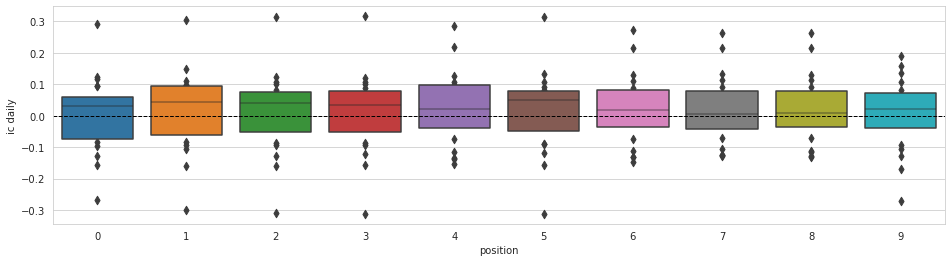

time: 51.8 s (started: 2021-05-01 14:39:30 +00:00)


In [14]:
num_models = 10

for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: 
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
              .set_index(['ticker','date'])
              .sort_index(level=['ticker','date'])
              .loc[idx[:, '2010': '2018'], :]
              )
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    #data = data.loc[:, features + [label]].dropna()
    data = data.loc[:, features + [label]] # keep rows of no label for trading purpose

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_models):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'Position: {position:02}')

        n_splits = int(val_length / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            if i > 1: # get latest period only
                break
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))
            train_test_periods_msg(train_idx, test_idx, data)
            
        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        
    by_day = test_predictions.groupby(level='date')
    for position in range(num_models):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
    test_predictions = test_predictions.sort_index(level=['ticker','date'])
    test_predictions.to_csv(path_result / f'prediction_{lookahead:02}.csv')

In [15]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19761 entries, ('1332.JP', Timestamp('2018-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-12-28 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_test  19761 non-null  float64
 1   0       19761 non-null  float64
 2   1       19761 non-null  float64
 3   2       19761 non-null  float64
 4   3       19761 non-null  float64
 5   4       19761 non-null  float64
 6   5       19761 non-null  float64
 7   6       19761 non-null  float64
 8   7       19761 non-null  float64
 9   8       19761 non-null  float64
 10  9       19761 non-null  float64
dtypes: float64(11)
memory usage: 1.8+ MB
time: 15.6 ms (started: 2021-05-01 14:42:42 +00:00)


In [17]:
!conda install -y -c quantopian ta-lib
!pip install pyfolio
# https://github.com/stefan-jansen/zipline-reloaded
!pip install zipline-reloaded
!pip install Logbook
!pip install ipython-autotime

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

time: 23.2 s (started: 2021-05-01 15:00:03 +00:00)


In [18]:
# modify timeseries.py of pyfolio
# src: https://github.com/quantopian/pyfolio/pull/634
!sed -i 's/valley = np.argmin(underwater)/valley = underwater.idxmin()/g' /opt/conda/lib/python3.7/site-packages/pyfolio/timeseries.py
!sed -i 's/if (len(returns) == 0) or (len(underwater) == 0):/if (len(returns) == 0) or (len(underwater) == 0) or np.min(underwater) == 0:/g' /opt/conda/lib/python3.7/site-packages/pyfolio/timeseries.py

time: 297 ms (started: 2021-05-01 15:06:12 +00:00)


In [19]:
### zipline path
import os, sys

zipline_root = path_home / 'zipline'
os.environ['ZIPLINE_ROOT'] = str(zipline_root)
sys.path.append(zipline_root.expanduser().as_posix())

custom_data_path = zipline_root / 'custom_data'
if not custom_data_path.exists():
    custom_data_path.mkdir()

time: 1.3 ms (started: 2021-05-01 15:06:14 +00:00)


In [20]:
%matplotlib inline
%load_ext autotime

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         get_open_orders, cancel_order,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import JP_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.87 s (started: 2021-05-01 15:06:16 +00:00)


In [21]:
!ln -s ../../data/stooq_jp_tse_stocks_prices.csv zipline/custom_data/.
!ln -s ../../data/stooq_jp_tse_stocks_tickers.csv zipline/custom_data/.

ln: failed to create symbolic link 'zipline/custom_data/./stooq_jp_tse_stocks_prices.csv': File exists
ln: failed to create symbolic link 'zipline/custom_data/./stooq_jp_tse_stocks_tickers.csv': File exists
time: 285 ms (started: 2021-05-01 15:06:19 +00:00)


In [22]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

time: 3.75 ms (started: 2021-05-01 15:06:21 +00:00)


In [23]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

time: 900 µs (started: 2021-05-01 15:06:22 +00:00)


In [24]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

time: 1.09 ms (started: 2021-05-01 15:06:23 +00:00)


In [25]:
import stooq_preprocessing
stooq_preprocessing.load('2018-11-29', '2018-12-28') 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71862 entries, ('1301.JP', Timestamp('2018-11-29 00:00:00+0000', tz='UTC')) to ('9997.JP', Timestamp('2018-12-28 00:00:00+0000', tz='UTC'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    71862 non-null  float64
 1   high    71862 non-null  float64
 2   low     71862 non-null  float64
 3   close   71862 non-null  float64
 4   volume  71862 non-null  float64
dtypes: float64(5)
memory usage: 3.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sid     3422 non-null   int64 
 1   ticker  3422 non-null   object
 2   name    3422 non-null   object
dtypes: int64(1), object(2)
memory usage: 80.3+ KB
None
time: 15.6 s (started: 2021-05-01 15:06:27 +00:00)


In [26]:
# TODO: how to reduce time?
!zipline ingest -b stooq

[2021-05-01 15:06:50.442945] INFO: zipline.data.bundles.core: Ingesting stooq.
Merging daily equity files:  [####################################]      
time: 47min 22s (started: 2021-05-01 15:06:47 +00:00)


In [27]:
bundle_data = bundles.load('stooq')

time: 384 ms (started: 2021-05-01 15:54:10 +00:00)


In [34]:
def load_predictions(bundle, positions=5):
    """
    positions: num of top positions to use
    """
    t = 1
    df = (pd.read_csv(path_result / f'prediction_{t:02}.csv', parse_dates=['date'])
            .set_index(['ticker','date'])
            .sort_index(level=['ticker','date'])      
         )
    df = df[~df.index.duplicated()].drop('y_test', axis=1)
    predictions = df.iloc[:, :positions].mean(1).to_frame('predictions')

    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predictions
            .tz_localize('UTC')), assets

predictions, assets = load_predictions(bundle_data)

time: 99.4 ms (started: 2021-05-01 15:56:48 +00:00)


In [36]:
predictions

ticker,1,5,6,13,15,33,34,35,36,43,...,3391,3392,3393,3395,3398,3410,3411,3413,3414,3415
date,,,,,,,,,,,,,,,,,,,,,
2018-11-29 00:00:00+00:00,0.000053,0.000231,0.000427,-0.001244,0.000407,0.000365,-0.002248,0.003256,-0.000925,0.000631,...,0.000212,0.000196,0.000512,0.000155,-0.001413,0.001555,-0.000247,0.000572,0.003187,0.000119
2018-11-30 00:00:00+00:00,-0.000409,-0.000295,0.000016,-0.001542,-0.000318,-0.001573,-0.003715,-0.000433,-0.000978,-0.001100,...,-0.000383,-0.000315,0.000073,-0.000185,-0.002555,0.000204,-0.001216,-0.000347,0.002373,-0.000275
2018-12-03 00:00:00+00:00,-0.000998,-0.004425,-0.005201,-0.004480,-0.004337,-0.004349,-0.010264,-0.011187,-0.008966,-0.007834,...,-0.004599,-0.010434,-0.004349,-0.006897,-0.004497,-0.012610,-0.004278,-0.004258,-0.012886,-0.005153
2018-12-04 00:00:00+00:00,0.001261,-0.000295,0.003049,0.001028,-0.002217,-0.002180,0.003947,0.003543,0.003201,0.005761,...,0.001679,0.003169,0.002884,0.001796,-0.002498,0.002998,0.001268,0.001115,0.002550,0.002857
2018-12-05 00:00:00+00:00,-0.008649,-0.007840,-0.008540,-0.017851,-0.008019,-0.016653,-0.014068,-0.013759,-0.005358,-0.009579,...,-0.011980,-0.009619,-0.017175,-0.018269,-0.016950,-0.018282,-0.012416,-0.006393,-0.015860,-0.005961
2018-12-06 00:00:00+00:00,-0.007070,-0.004223,-0.007690,-0.001060,-0.004347,-0.004275,-0.006701,-0.009770,-0.008960,-0.008877,...,-0.004041,-0.007944,-0.001406,-0.001251,-0.001604,-0.006855,-0.004082,-0.004228,-0.003667,-0.004739
2018-12-07 00:00:00+00:00,-0.009355,-0.010777,-0.010585,-0.012554,-0.012771,-0.012980,-0.012586,-0.012657,-0.012007,-0.003657,...,-0.013156,-0.010609,-0.012553,-0.013477,-0.013023,-0.006262,-0.013794,-0.010696,-0.005699,-0.006287
2018-12-10 00:00:00+00:00,-0.004649,-0.002848,-0.009563,0.002246,-0.000873,0.002763,-0.001613,-0.004607,-0.008650,-0.008651,...,-0.002839,-0.007761,0.002732,0.002213,0.002760,-0.006526,0.002699,-0.003183,-0.006625,-0.003746
2018-12-11 00:00:00+00:00,0.000597,0.002749,0.003066,0.005051,0.002841,0.003458,0.003046,0.002981,0.002696,0.000969,...,0.003154,0.002245,0.003496,0.003399,0.003014,0.000172,0.002553,0.002694,0.001569,-0.002365


time: 38.1 ms (started: 2021-05-01 15:57:04 +00:00)


In [37]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = JP_EQUITIES
    
signal_loader = {SignalData.predictions:
                 DataFrameLoader(SignalData.predictions, predictions)}

time: 4.23 ms (started: 2021-05-01 15:57:12 +00:00)


In [38]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

        
def compute_signals():
    signals = MLSignal()
    predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs': signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
        screen=StaticAssets(assets)
    )


def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.05, min_trade_cost=1))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')
    
    
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())
    
    
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)

    positions = context.portfolio.positions
    s = (pd.Series({s: v.amount*v.last_sale_price for s,
                    v in positions.items()})
         .sort_values(ascending=False))
    
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)

    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)
                

def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

time: 2.69 ms (started: 2021-05-01 15:57:13 +00:00)


In [41]:
dates = predictions.index.get_level_values('date')
#start_date = dates.min() + pd.DateOffset(day=1)
start_date = dates.min()
end_date = dates.max()
print('Start:\t{}\nEnd:\t{}'.format(start_date.date(), end_date.date()))

Start:	2018-11-29
End:	2018-12-28
time: 1.23 ms (started: 2021-05-01 15:59:08 +00:00)


In [42]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='stooq',
                        custom_loader=signal_loader)

print('Duration: {:.2f}s'.format(time() - start))

[2021-05-01 15:59:11.578982]: INFO: handle_simulation_end: Simulated 20 trading days
first open: 2018-11-29 14:31:00+00:00
last close: 2018-12-28 21:00:00+00:00


Duration: 1.29s
time: 1.29 s (started: 2021-05-01 15:59:10 +00:00)


In [43]:
index=-1

time: 531 µs (started: 2021-05-01 15:59:15 +00:00)


In [44]:
results.iloc[index]

period_open                                        2018-12-28 14:31:00+00:00
period_close                                       2018-12-28 21:00:00+00:00
ending_exposure                                                    -15694.91
starting_value                                                       41239.5
net_leverage                                                       -0.014827
ending_value                                                       -15694.91
starting_cash                                                    1017948.677
ending_cash                                                      1074230.137
portfolio_value                                                  1058535.227
longs_count                                                               25
shorts_count                                                              25
long_value                                                        1037174.48
returns                                                            -0.000616

time: 51.6 ms (started: 2021-05-01 15:59:16 +00:00)


In [45]:
# TODO: make compact
results.iloc[index].orders

[{'id': 'b137ccb22cf94d33974e6b7d5e0154fd',
  'dt': Timestamp('2018-12-28 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2018-12-27 21:00:00+0000', tz='UTC'),
  'amount': -30,
  'filled': -30,
  'commission': 1.5,
  'stop': None,
  'limit': None,
  'stop_reached': False,
  'limit_reached': False,
  'sid': Equity(3211 [9504.JP]),
  'status': 1},
 {'id': '44f582e184ad45af991efd71a6047fab',
  'dt': Timestamp('2018-12-28 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2018-12-27 21:00:00+0000', tz='UTC'),
  'amount': -60,
  'filled': -60,
  'commission': 3.0,
  'stop': None,
  'limit': None,
  'stop_reached': False,
  'limit_reached': False,
  'sid': Equity(3211 [9504.JP]),
  'status': 1},
 {'id': '63da4d02a3ec445c9b4be78eb717d5eb',
  'dt': Timestamp('2018-12-28 21:00:00+0000', tz='UTC'),
  'reason': None,
  'created': Timestamp('2018-12-27 21:00:00+0000', tz='UTC'),
  'amount': -23,
  'filled': -23,
  'commission': 1.1500000000000001,
  'stop': N

time: 44.7 ms (started: 2021-05-01 15:59:24 +00:00)


In [ ]:
results.iloc[index].transactions

In [46]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

time: 149 ms (started: 2021-05-01 15:59:33 +00:00)


In [47]:
transactions.tail()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2018-12-28 21:00:00+00:00,Equity(2283 [7102.JP]),Equity(2283 [7102.JP]),2192.28,50f8e9c49021409aae90aa548cbbd886,19,None,2018-12-28 21:00:00+00:00,-41653.32
2018-12-28 21:00:00+00:00,Equity(2333 [7238.JP]),Equity(2333 [7238.JP]),183.00,78cd5dc44eaa4182b2fda32b164a54bf,232,None,2018-12-28 21:00:00+00:00,-42456.00
2018-12-28 21:00:00+00:00,Equity(2366 [7287.JP]),Equity(2366 [7287.JP]),1773.09,cc15b60ab10444b4ae10fc0859e16f0e,24,None,2018-12-28 21:00:00+00:00,-42554.16
2018-12-28 21:00:00+00:00,Equity(2517 [7701.JP]),Equity(2517 [7701.JP]),2126.55,4006774406e5429d902e6ecb733c7cd3,19,None,2018-12-28 21:00:00+00:00,-40404.45
2018-12-28 21:00:00+00:00,Equity(3411 [9984.JP]),Equity(3411 [9984.JP]),3606.34,ab7257a6699c4b08b488f4e5d91fc5ed,11,None,2018-12-28 21:00:00+00:00,-39669.74


time: 15.1 ms (started: 2021-05-01 15:59:35 +00:00)


In [48]:
returns

2018-11-29 00:00:00+00:00    0.000000
2018-11-30 00:00:00+00:00    0.000000
2018-12-03 00:00:00+00:00   -0.000079
2018-12-04 00:00:00+00:00    0.007791
2018-12-06 00:00:00+00:00    0.008557
2018-12-07 00:00:00+00:00   -0.008096
2018-12-10 00:00:00+00:00    0.006580
2018-12-11 00:00:00+00:00   -0.000076
2018-12-12 00:00:00+00:00    0.025071
2018-12-13 00:00:00+00:00   -0.001020
2018-12-14 00:00:00+00:00   -0.000086
2018-12-17 00:00:00+00:00   -0.009385
2018-12-18 00:00:00+00:00   -0.000122
2018-12-19 00:00:00+00:00    0.011292
2018-12-20 00:00:00+00:00    0.013021
2018-12-21 00:00:00+00:00   -0.000208
2018-12-24 00:00:00+00:00    0.000000
2018-12-26 00:00:00+00:00   -0.005266
2018-12-27 00:00:00+00:00    0.010216
2018-12-28 00:00:00+00:00   -0.000616
Name: returns, dtype: float64

time: 5.56 ms (started: 2021-05-01 16:00:19 +00:00)
